In [1]:
import pulpy as pp
import pulpy.rf as rf
import pulpy.grad as grad
import numpy as np

from sigpy import plot as pl
from scipy.io import loadmat, savemat 
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt 

/home/jonathanmartin/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# design a bssel pulse 
dtb1sel = 1e-6
bsrf, rfp, rw = rf.b1sel.dz_bssel_rf(dt=dtb1sel, bs_offset=5000)

RW kbs = -28.187760052286578
SS modulation = 1579.910473171051 Hz


/home/jonathanmartin/anaconda3/envs/py39/lib/python3.9/site-packages/pulpy/rf/util.py:47: RuntimeWarning: invalid value encountered in sqrt
  b1 = (wrf / gam) * np.sqrt((1 + bs_offset / wrf) ** 2 - 1)


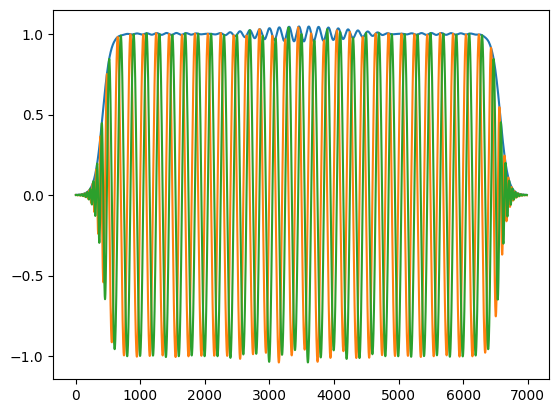

In [9]:
rfb1sel = bsrf + rfp
plt.plot(np.abs(rfb1sel.flatten()))
plt.plot(np.real(rfb1sel.flatten()))
plt.plot(np.imag(rfb1sel.flatten()))

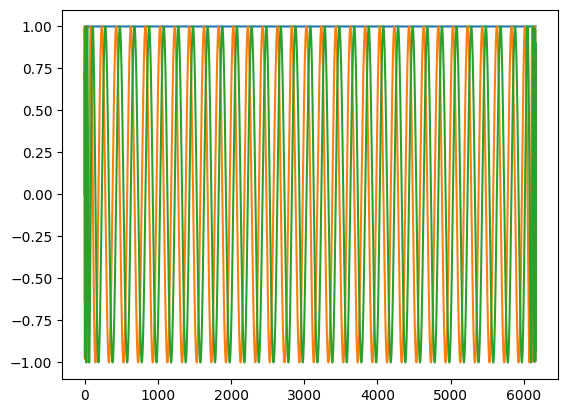

In [10]:
rfflat = pp.verse.flatten_bsse(rfb1sel, dtb1sel)
plt.plot(np.abs(rfflat.flatten()))
plt.plot(np.real(rfflat.flatten()))
plt.plot(np.imag(rfflat.flatten()))

In [11]:
def rfSimCplx(rf, gamgdt, xx):

    Ns = np.size(xx) # Ns: # of spatial locs
    Nt = np.size(gamgdt) # Nt: # time points

    a = np.ones((Ns,))
    b = np.zeros((Ns,))

    Qc = np.cos(np.pi / 4)
    Qs = np.sin(np.pi / 4)

    for ii in range(Nt):

        # apply phase accural
        z = np.exp(-1j * (xx * gamgdt[ii]))
        b = b * z

        # apply rf
        C = np.cos(np.abs(rf[ii]) / 2)
        S = 1j * np.exp(1j * np.angle(rf[ii])) * np.sin(np.abs(rf[ii]) / 2)
        at = a * C - b * np.conj(S)
        bt = a * S + b * C
        a = at
        b = bt

    z = np.exp(1j / 2 * (xx * np.sum(gamgdt)))
    a = a * z
    b = b * z

    return a, b

Text(0, 0.5, '|Mxy|')

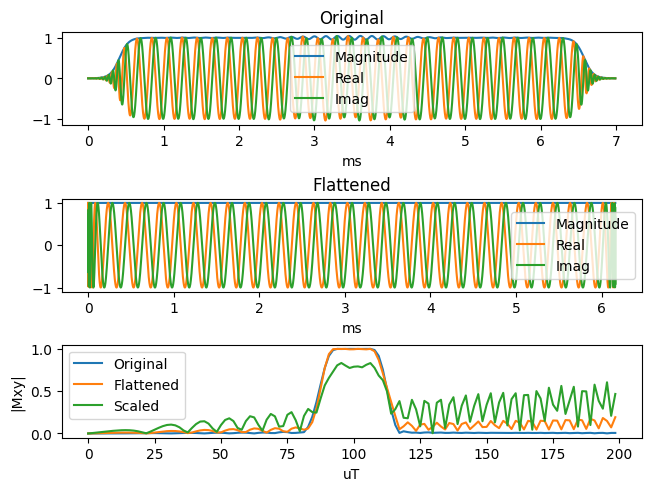

In [12]:
N = 128 # number of frequency and b1 points to simulate 

xx = dtb1sel * 2 * np.pi * np.arange(-1000, 1000, 2000 / N).reshape((N,))
xx = np.array([0])
omOffRes = np.ones((rfb1sel.size,))

MxyOrig = np.zeros((N, N), dtype=complex)

b1 = np.arange(0, 2, 2 / 128) # 0-40 Gauss

# run simulation, looping over b1 amplitudes
for i in range(N):
    a, b = rfSimCplx(dtb1sel * 2 * np.pi * 4258 * b1[i] * rfb1sel.flatten(), omOffRes, xx)
    MxyOrig[:, i] = 2 * np.conj(a) * b 

#pl.ImagePlot(Mxy)

#%%
omOffRes = np.ones((rfflat.size,))
MxyFlat = np.zeros((N, N), dtype=complex)

# run simulation, looping over b1 amplitudes
for i in range(N):
    a, b = rfSimCplx(dtb1sel * 2 * np.pi * 4258 * b1[i] * rfflat.flatten(), omOffRes, xx)
    MxyFlat[:, i] = 2 * np.conj(a) * b 

#pl.ImagePlot(Mxy)

#%%
omOffRes = np.ones((rfb1sel.size,))
MxyClipped = np.zeros((N, N), dtype=complex)

# run simulation, looping over b1 amplitudes
for i in range(N):
    a, b = rfSimCplx(dtb1sel * 2 * np.pi * 4258 * b1[i] * rfb1sel.flatten() / np.abs(rfb1sel.flatten()), omOffRes, xx)
    MxyClipped[:, i] = 2 * np.conj(a) * b 

#pl.ImagePlot(Mxy)

#%% 
fig, axs = plt.subplots(3, 1, layout='constrained')
axs[0].plot(dtb1sel * 1000 * np.arange(rfb1sel.size), np.abs(rfb1sel.flatten()), label='Magnitude')
axs[0].plot(dtb1sel * 1000 * np.arange(rfb1sel.size), np.real(rfb1sel.flatten()), label='Real')
axs[0].plot(dtb1sel * 1000 * np.arange(rfb1sel.size), np.imag(rfb1sel.flatten()), label='Imag')
axs[0].set_title('Original')
axs[0].legend()
axs[0].set_xlabel('ms')
axs[1].plot(dtb1sel * 1000 * np.arange(rfflat.size), np.abs(rfflat), label='Magnitude')
axs[1].plot(dtb1sel * 1000 * np.arange(rfflat.size), np.real(rfflat), label='Real')
axs[1].plot(dtb1sel * 1000 * np.arange(rfflat.size), np.imag(rfflat), label='Imag')
axs[1].set_title('Flattened')
axs[1].legend()
axs[1].set_xlabel('ms')
axs[2].plot(b1 * 100, np.abs(MxyOrig[0,:]), label='Original')
axs[2].plot(b1 * 100, np.abs(MxyFlat[0,:]), label='Flattened')
axs[2].plot(b1 * 100, np.abs(MxyClipped[0,:]), label='Scaled')
axs[2].legend()
axs[2].set_xlabel('uT')
axs[2].set_ylabel('|Mxy|')

In [7]:
plt.show()